<a href="https://colab.research.google.com/github/HeqingZ/R50ReRun/blob/main/R50_ReRun_2ndTime_1x_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preliminary Setup

In [1]:
#install detectron2
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 5.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=eab1c0f61a7f097217f847ad8cd994718ef6918c441bba4fcb60fcdb127338e6
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/d

In [1]:
#import some important utilities of Detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#import features for the bbox
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from detectron2.structures import BoxMode

In [3]:
#mount on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataloader

In [4]:
def FLIR(source_path, img_dir, anno_dir): 
  img_dir = os.path.join(source_path, img_dir)
  anno_dir = os.path.join(source_path, anno_dir)
  data_dicts = []
  #define annotation properties
  with open(anno_dir) as F:
    jsonfile = json.load(F)
  
  annotationinfo = jsonfile['annotations']
  imagesinfo = jsonfile['images']

  #define img sources

  img_dir_list = os.listdir(img_dir)
  #print(img_dir)
  for img_info in imagesinfo:
    for images in img_dir_list:
      images = 'data/' + images
      if images == img_info['file_name']:

        record = {}
        filename = os.path.join(source_path, img_info['file_name'])
        #print(filename)
        record['file_name']=filename
        record['image_id']=img_info['id']
        record['height'] = img_info['height']
        record['width'] = img_info['width']

        box_info = []

        for anno in annotationinfo:
          if anno['image_id'] == img_info['id']:
            if (anno['category_id'] == 1) & (anno['category_id']>0):
              box = {
              'bbox':anno['bbox'],
              'bbox_mode':BoxMode.XYWH_ABS,
              'category_id':int(anno['category_id']-1)
              }
              imagetesthaha = cv2.imread(filename, 0)
              tt = cv2.rectangle(imagetesthaha, anno['bbox'], (255,0,0),2)
              box_info.append(box)
        record['annotations']=box_info

        data_dicts.append(record)
  return data_dicts
      

In [ ]:
DatasetCatalog.clear()

In [5]:
for d in ['train', 'val']:
  DatasetCatalog.register('FLIR_THERMAL_'+ d + '_data', lambda d=d: FLIR('/content/drive/MyDrive/FLIR_THERMAL/train', 'data','coco.json'))
  MetadataCatalog.get('FLIR_THERMAL_' + d + "_data").set(thing_classes = ['FLIR_THERMAL'])
FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")

                                                        

In [6]:
#call function
dataset_dicts = FLIR('/content/drive/MyDrive/FLIR_THERMAL/train', 'data', 'coco.json')

Train the program

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'))
cfg.DATASETS.TRAIN = ("FLIR_THERMAL_train_data",)
cfg.MODEL.RESNETS.DEPTH = 50 #for mvit v2 S we are setting the depth = 101. (F)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people 'changed to 2'
cfg.SOLVER.BASE_LR = 0.000025 #SET ALL TO 0.0001
cfg.SOLVER.MAX_ITER = 90000    # 270000 for 3x (F)
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 3500 #changed to 3500
cfg.SOLVER.WARMUP_ITERS = 3500 #must match teh denom of the warmup factor
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # chose 512 for 3x
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (people). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False
# cfg.MODEL.RESNETS.DEFORM_MODULATED = True
cfg.MODEL.BACKBONE.FREEZE_AT = 0
cfg.OUTPUT_DIR = "/content/drive/MyDrive/R50ReRunTest1x"


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()



[08/21 19:51:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [8]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # ALL THRESHOLD = 0.5
#Pass the validation dataset
cfg.DATASETS.TEST = ("boardetect_val", )

predictor = DefaultPredictor(cfg)

[08/21 20:03:35 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


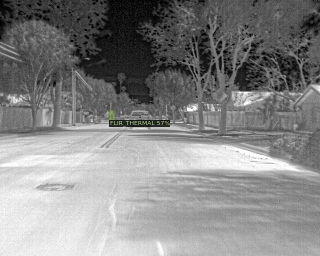

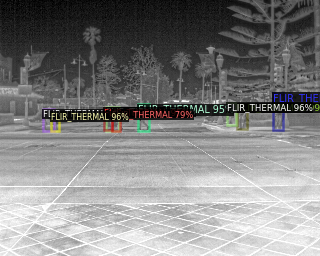

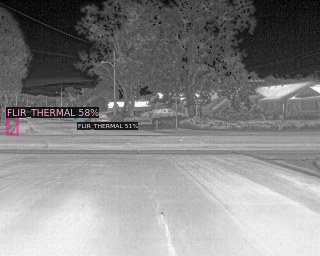

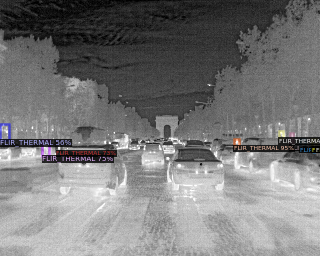

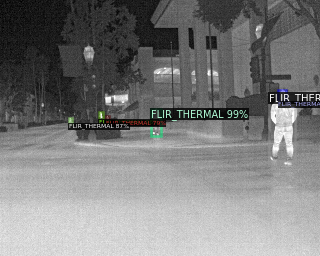

In [9]:
#see if this shit is wroking aka run instance on test images
from detectron2.utils.visualizer import ColorMode
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/val/", "data", "coco.json")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Evaluation

In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #ALL THRESHOLD = 0.5 
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("FLIR_THERMAL_train_data", cfg, False, output_dir="content/output/")
val_loader = build_detection_test_loader(cfg, "FLIR_THERMAL_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

[08/21 20:04:32 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

OrderedDict([('bbox',
              {'AP': 40.14081668320736,
               'AP50': 78.74044826906335,
               'AP75': 35.98749753163052,
               'APs': 37.05307674449343,
               'APm': 51.53653711499473,
               'APl': 49.01957675125538})])